In [1]:
import pandas as pd
import re
from collections import Counter
import numpy as np
import os
import yaml
import lightgbm as lgb
import matplotlib.pyplot as plt
import optuna
from dateutil.relativedelta import relativedelta

## Reading Data

本ステップでは、学習に必要な JRDB データを準備します。  
JRDB では複数の固定長形式ファイルが提供されており、それぞれ競馬に関する異なる情報を含んでいます。  
ここでは主に以下のデータを利用します。

- **JRDB競走馬データ**: 出走馬に関する情報  
- **JRDB番組データ**: レース番組に関する情報（開催場、条件など）  
- **JRDB馬基本データ**: 各馬の基本属性（年齢、性別、血統など）  
- **JRDB直前情報データ**: レース直前の状態に関する情報（馬体重、パドック、調教師コメントなど）  
- **JRDB成績データ**: 過去のレース結果（本タスクのラベルとして利用）

生データには多くのカラムが含まれているため、予測タスクに関連するカラムのみを抽出します。  
さらに、各データセットについて以下のように型を定義します。

- **数値特徴量**（例: 馬体重、オッズ、スピード指数 など）  
- **カテゴリ特徴量**（例: 性別、騎手ID、競馬場コード など）

必要なカラムを選択し、数値・カテゴリに整理した後、これらのデータを一つの **DataFrame** に結合します。  
この統合された DataFrame には、**特徴量**（馬・レース・直前情報）と、**ラベル**（JRDB成績データから取得した着順）が含まれます。  

この DataFrame をモデル学習の基盤として利用します。

In [2]:
def parse_jrdb_schema(doc_path, encoding="cp932"):
    """
    Parse a JRDB schema definition document to extract column names and field widths.
    The schema file is expected to contain one column definition per line,
    where each line includes the column name followed by its byte length.
    Example of a valid line:
        馬名    40
    """
    with open(doc_path, encoding=encoding) as f:
        lines = f.readlines()

    columns = []
    widths = []

    for line in lines:
        # Skip empty/separator/metadata lines
        if not line.strip() or line.startswith("*") or "レコード長" in line:
            continue

        # Match "項目名 + BYTE"
        m = re.match(r'\s*([^\s]+)\s+(\d+)\s+', line)
        if m:
            col_name = m.group(1)
            width = int(m.group(2))
            columns.append(col_name)
            widths.append(width)

    # Ensure unique column names
    counts = Counter()
    unique_columns = []
    for col in columns:
        if counts[col]:
            new_col = f"{col}_{counts[col]+1}"
        else:
            new_col = col
        counts[col] += 1
        unique_columns.append(new_col)

    return unique_columns, widths

In [3]:
def parse_fixed_width_file(filepath, schema, encoding="cp932"):
    """
    Read JRDB fixed-width binary file as bytes, slice by byte widths,
    decode each field, return pandas DataFrame.
    """
    colnames = [col for col, width in schema]
    colwidths = [width for col, width in schema]

    rows = []
    with open(filepath, "rb") as f:  # keep in bytes
        for line in f:
            record = {}
            pos = 0
            for (col, width) in schema:
                raw = line[pos:pos+width]
                try:
                    text = raw.decode(encoding).strip()
                except UnicodeDecodeError:
                    text = raw.decode(encoding, errors="replace").strip()
                record[col] = text
                pos += width
            rows.append(record)

    return pd.DataFrame(rows, columns=colnames)

def load_jrdb_batch(base_dir, schema, prefix):
    """
    Recursively scan a base directory, find all files whose names start with 
    a given prefix, and load them into a single DataFrame.
    """
    all_dfs = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.startswith(prefix):
                filepath = os.path.join(root, file)
                df = parse_fixed_width_file(filepath, schema)
                all_dfs.append(df)
    if all_dfs:
        return pd.concat(all_dfs, ignore_index=True)
    else:
        return pd.DataFrame(columns=[col for col, _ in schema])

### Load JRDB競走馬データ

In [4]:
# FIXME: possibly make クラスコード numerical
# split 体型, currently dropped
# TODO: possibly reduce noise by considering e.g. 不利

CAT_COLS = ["場コード", "脚質", "距離適性", "厩舎評価コード", "蹄形状", "重適正コード", "クラスコード",
            "ブリンカー", "騎手名", "見習い区分", "調教師名", "調教師所属", "激走印", "条件クラス",  "展開記号",
            "距離適性２", "性別コード", "馬記号コード", "輸送区分", "体型総合１", "体型総合２", "体型総合３",
            "馬特記１", "馬特記２", "馬特記３", "降級フラグ", "激走タイプ", "休養理由分類コード", "フラグ", 
           ]
ID_COLS = ["血統登録番号"]
EXTKEY_COLS = ["前走１競走成績キー", "前走２競走成績キー", "前走３競走成績キー", "前走４競走成績キー", "前走５競走成績キー",
         "前走１レースキー", "前走２レースキー", "前走３レースキー", "前走４レースキー", "前走５レースキー",
         "騎手コード", "調教師コード", 
        ]
NUM_COLS = ["年", "回", "日", "Ｒ", "馬番", "ＩＤＭ", "騎手指数", "情報指数", "総合指数", "上昇度", "調教矢印コード",
             "ローテーション", "基準オッズ", "基準人気順位", "基準複勝オッズ", "基準複勝人気順位", "特定情報◎", "特定情報○",
             "特定情報▲", "特定情報△", "特定情報×", "総合情報◎", "総合情報○", "総合情報▲", "総合情報△", "総合情報×",
             "人気指数", "調教指数", "厩舎指数", "騎手期待連対率", "激走指数", "負担重量", "枠番", "総合印", "ＩＤＭ印",
             "情報印", "騎手印", "厩舎印", "調教印", "芝適性コード", "ダ適性コード", "獲得賞金", "収得賞金", "テン指数",
             "ペース指数", "上がり指数", "位置指数", "ペース予想", "道中順位", "道中差",  "道中内外", "後３Ｆ順位",
             "後３Ｆ差", "後３Ｆ内外", "ゴール順位", "ゴール差", "ゴール内外", "激走順位", "LS指数順位", "テン指数順位",
             "ペース指数順位", "上がり指数順位", "位置指数順位", "騎手期待単勝率", "騎手期待３着内率", "馬スタート指数", "馬出遅率",
             "万券指数", "万券印", "入厩何走目", "入厩何日前", "放牧先ランク", "厩舎ランク", "蹄サイズ", ]
DROP_COLS = ["馬名", "予備１", "予備２", "予備３", "予備", "予備_2", "予備_3", "枠確定馬体重", "枠確定馬体重増減", "取消フラグ",
            "馬主名", "馬主会コード", "走法", "体型", "参考前走", "参考前走騎手コード", "入厩年月日", "放牧先", "予備_4",
             "改行", "体型", ]
RACE_KEYS = ["場コード", "年", "回", "日", "Ｒ"]
KEY_COLS = RACE_KEYS + ["馬番"]

columns, widths = parse_jrdb_schema("jrdb_docs/kyi_doc.txt")
df_kyi = load_jrdb_batch("data/jrdb/extracted", list(zip(columns, widths)), "KYI")
df_kyi = df_kyi.drop(EXTKEY_COLS + DROP_COLS, axis=1)

### Load JRDB番組データ

In [5]:
DATE_COL = "年月日"
BAC_NUM_COLS = ["距離", "頭数", ] 
BAC_CAT_COLS = ["芝ダ障害コード", "右左", "内外", "種別", "条件", "記号", "重量", "グレード", "コース", "開催区分", ]
NUM_COLS = NUM_COLS + BAC_NUM_COLS
CAT_COLS = CAT_COLS + BAC_CAT_COLS
columns, widths = parse_jrdb_schema("jrdb_docs/bac_doc.txt")
df_bac = load_jrdb_batch("data/jrdb/extracted", list(zip(columns, widths)), "BAC")
df_bac[DATE_COL] = pd.to_datetime(df_bac[DATE_COL], format="%Y%m%d")
df_bac = df_bac[[DATE_COL] + RACE_KEYS + BAC_NUM_COLS + BAC_CAT_COLS]

assert df_kyi[RACE_KEYS].drop_duplicates().shape[0]==len(df_bac)
df = df_kyi.merge(df_bac, on=RACE_KEYS, how="left")

### Load JRDB馬基本データ

In [6]:
# Data is a bit broken due to misspelling
UKC_CAT_COLS = ["父馬名", "母父馬名", "父系統コード", "母父系統コード"]
CAT_COLS = CAT_COLS + UKC_CAT_COLS
columns, widths = parse_jrdb_schema("jrdb_docs/ukc_doc.txt")
df_ukc = load_jrdb_batch("data/jrdb/extracted", list(zip(columns, widths)), "UKC")
df_ukc = df_ukc[["血統登録番号"] + UKC_CAT_COLS]
df_ukc = df_ukc.drop_duplicates(subset=["血統登録番号"])

missing_keys = set(df["血統登録番号"]) - set(df_ukc["血統登録番号"])
assert not missing_keys, f"The following 血統登録番号 are missing in df_ukc: {missing_keys}"
df = df.merge(df_ukc, on="血統登録番号", how="left")

### Load JRDB直前情報データ

In [7]:
TYB_NUM_COLS = ["オッズ指数", "パドック指数", "総合指数2", "馬体重", "馬体重増減", "馬場状態コード", "単勝オッズ", "複勝オッズ", ]
TYB_CAT_COLS = ["馬具変更情報", "脚元情報", "天候コード", "オッズ印", "パドック印", "馬体コード", "気配コード", "直前総合印"]
NUM_COLS = NUM_COLS + TYB_NUM_COLS
CAT_COLS = CAT_COLS + TYB_CAT_COLS
columns, widths = parse_jrdb_schema("jrdb_docs/tyb_doc.txt")
df_tyb = load_jrdb_batch("data/jrdb/extracted", list(zip(columns, widths)), "TYB")
df_tyb = df_tyb.rename(columns={"総合指数": "総合指数2"})
df_tyb = df_tyb[KEY_COLS + TYB_NUM_COLS + TYB_CAT_COLS]

assert len(df)==len(df_tyb)
df = pd.merge(df, df_tyb, on=KEY_COLS, how="left")

### Load JRDB成績データ

In [8]:
RES_COLS = ["着順", "10時単勝オッズ", "確定単勝オッズ", "単勝", "複勝"]
columns, widths = parse_jrdb_schema("jrdb_docs/sed_doc.txt")
df_sed = load_jrdb_batch("data/jrdb/extracted", list(zip(columns, widths)), "SED")
df_sed = df_sed[KEY_COLS + RES_COLS]

assert len(df)==len(df_sed)
df = pd.merge(df, df_sed, on=KEY_COLS, how="left")

## Data Preprocessing

LightGBM で学習を行うためには、各特徴量を適切な型に変換する必要があります。  
具体的には、カテゴリ変数は **pandas の Categorical 型** に、数値変数は **int または float 型** に変換しました。  

また、データに含まれる一部の文字コードや記号（例: 蹄コード、日付コード、ペース予想、放牧ランク、馬体重増減など）は数値へマッピングして扱えるようにしています。  

さらに、学習用のデータとしてより一貫性を保つために以下のフィルタリングを行いました。

- **未完走（着順=0）の馬を除外**  
- **芝レースのみを対象**（障害・ダートレースは除外）  

実際にモデルを試したところ、芝レースの方が予測精度が高い傾向が見られたため、このようなデータ選択を採用しました。


In [9]:
def split_hoof_code(df, col="蹄コード"):
    sizes = []
    shapes = []
    # Map sizes to numeric
    size_mapping = {"大": 4, "中": 3, "小": 2, "細": 1}
    
    # Mapping table from code to (size, shape)
    code_to_size_shape = {
        1: ("大", "ベタ"), 2: ("中", "ベタ"), 3: ("小", "ベタ"), 4: ("細", "ベタ"),
        5: ("大", "立"), 6: ("中", "立"), 7: ("小", "立"), 8: ("細", "立"),
        9: ("大", "標準"), 10: ("中", "標準"), 11: ("小", "標準"), 12: ("細", "標準"),
        17: ("大", "標起"), 18: ("中", "標起"), 19: ("小", "標起"), 20: ("細", "標起"),
        21: ("大", "標ベ"), 22: ("中", "標ベ"), 23: ("小", "標ベ"), 24: ("細", "標ベ")
    }

    for val in df[col]:
        try:
            code = int(val)
            size_str, shape = code_to_size_shape.get(code, (np.nan, np.nan))
        except ValueError:
            size_str, shape = np.nan, np.nan
        
        # Convert size to numeric
        size_num = size_mapping.get(size_str, np.nan)
        sizes.append(size_num)
        shapes.append(shape)
    
    df["蹄サイズ"] = sizes        # numeric
    df["蹄形状"] = shapes        # keep as object (can convert to categorical later)

    df = df.drop("蹄コード", axis=1)
    
    return df

def day_code_to_int(val):
    val = str(val).lower()
    if val.isdigit():
        return int(val)
    elif val.isalpha():
        return ord(val) - ord('a') + 10
    else:
        raise ValueError(f"Unexpected value: {val}")

def pace_to_numeric(val):
    if isinstance(val, (int, float)):
        return val
    mapping = {'S': 1, 'M': 2, 'H': 3, '': None}
    return mapping.get(val, None)  # handle lowercase too

def houbou_to_numeric(val):
    if isinstance(val, (int, float)):
        return val
    mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, '': None}
    return mapping.get(val, None)

def convert_to_numeric(df, cols):
    converted = df.copy()
    for col in cols:
        if col not in converted.columns:
            raise KeyError(f"Column '{col}' not found in DataFrame")

        converted[col] = pd.to_numeric(
            converted[col].replace("", np.nan),
        )
    # Check only the specified columns
    non_numeric = [
        col for col in cols 
        if not pd.api.types.is_numeric_dtype(converted[col])
    ]
    if non_numeric:
        raise ValueError(f"Non-numeric columns remain: {non_numeric}")

    return converted

def make_categorical(df, cols):
    df = df.copy()
    for col in cols:
        df[col] = pd.Categorical(df[col])
    return df

def signed_str_to_numeric(val):
    val = val.replace(" ", "")
    return pd.to_numeric(val)

df = df.drop(ID_COLS, axis=1)
df = split_hoof_code(df)
df["日"] = df["日"].apply(day_code_to_int)
df["ペース予想"] = df["ペース予想"].apply(pace_to_numeric)
df["放牧先ランク"] = df["放牧先ランク"].apply(houbou_to_numeric)
df["馬体重増減"] = df["馬体重増減"].apply(signed_str_to_numeric)
df = convert_to_numeric(df, NUM_COLS + RES_COLS)
df[["単勝", "複勝"]] = df[["単勝", "複勝"]].fillna(0)
df = df[df["着順"]!=0] # drop rows with horses could not finish race
df = df[df["芝ダ障害コード"]=='1'] # no shogai, no dart, only shiba
df = make_categorical(df, CAT_COLS)

## Train Model

本節では、LightGBMによる学習用データセットの作成方法と、学習モードについて説明します。

### 学習モード

今回のモデルでは3つのモードを用意しています：

- **rank**：グループ内の順位を学習するモード。レースごとの相対順位を学習します。  
- **binary**：トップ3に入るか否かを2値で学習するモード。  
- **multiclass**：着順を複数クラス（1着〜5着、6着以降など）として学習するモード。  

ラベルは `generate_y` 関数で、モードに応じて自動生成されます。

#### 各モードのメリット・デメリット

- **rank モード**
  - **メリット**：同じレースの他の馬との相対的な順位を学習できるため、1着になる確率の相対的な予測精度が高くなる。
  - **デメリット**：直接的な勝つ確率を学習するわけではないため、確率値としての解釈は難しい。

- **binary モード**
  - **メリット**：勝つ確率を直接学習できる。
  - **デメリット**：同じレース内の他の馬の情報を考慮できない。さらにクラスの不均衡（勝つ馬は少数、負ける馬が多数）が大きくなるため学習が難しい場合がある。

- **multiclass モード**
  - **メリット**：1着〜5着など複数クラスを学習することで、勝率を直接確率として予測できる。  
    さらに1着以外のクラスを作ることでクラスの偏りを抑え、1着確率の予測精度向上にも寄与する。
  - **デメリット**：レース内の他の馬との相対関係は考慮されない。

本モデルでは、「勝つ確率」をできるだけ正確に予測することが目的であるため、**multiclass モード**を採用することで、確率学習とクラスバランスの両立を図っています。

---

### データ分割

学習用、検証用、テスト用のデータは、日付を基準に簡単に設定可能です。  
- `valid_start` / `valid_end` を指定することで、任意の期間を検証用データにできます。  
- テスト用データは、検証期間の直後の同じ長さの期間として自動生成されます。  
- KFold学習も対応しており、期間をシフトしながら複数foldを作成できます。

通常のKFoldは時系列データには使えません。なぜなら、将来のデータを過去の学習データに含めてしまう可能性があるためです。そのため本モデルでは、**検証期間とテスト期間が常に未来のデータになるように**データを分割しています。

具体例を示します：

- **最初の分割**
  - 学習用: ～2025/01
  - 検証用: 2025/02
  - テスト用: 2025/03

- **次の分割**
  - 学習用: ～2025/02
  - 検証用: 2025/03
  - テスト用: 2025/04

- **さらに次の分割**  
  このように、検証期間とテスト期間を順にシフトさせながら複数foldを作成します。

この分割は `split_train_valid_test` 関数でマスクを作成し、`generate_dataset` や `generate_kfold_datasets` でLightGBM用のデータセットに変換されます。  
これにより、**時系列の順序を保ったままKFold評価**が可能になり、将来のデータを学習に含めることなくモデル性能を評価できます。

---

### ハイパーパラメータ

LightGBMのパラメータは外部ファイル params_lightgbm.yaml から読み込みます。
モードごとに最適化されたパラメータセットを利用できるため、rank / binary / multiclass で切り替えが容易です。

In [10]:
def period_to_days(valid_period: str) -> int:
    """Convert period string (e.g., '6M', '1Y') to approximate days."""
    if valid_period.endswith("M"):
        return int(valid_period[:-1]) * 30
    elif valid_period.endswith("Y"):
        return int(valid_period[:-1]) * 365
    else:
        raise ValueError("valid_period must end with 'M' or 'Y'")

def split_train_valid_test(df, valid_start, valid_end):
    """Mask train, valid, test dataframes given period boundaries."""
    test_start, test_end = valid_end, valid_end + (valid_end - valid_start)

    train_mask = df[DATE_COL] <= valid_start
    valid_mask = (df[DATE_COL] > valid_start) & (df[DATE_COL] <= valid_end)
    test_mask = (df[DATE_COL] > test_start) & (df[DATE_COL] <= test_end)

    return train_mask, valid_mask, test_mask

def generate_y(df, mode):
    y = df[KEY_COLS + RES_COLS].copy()
    if mode == "rank":
        y["label"] = df.groupby(RACE_KEYS, observed=True)["着順"].transform(lambda x: x.max() - x)
    elif mode == "binary":
        y["label"] = (df["着順"] == 1).astype(int)
    elif mode=="multiclass":
        y["label"] = (df["着順"] - 1).clip(upper=5)
    else:
        raise ValueError(f"Unknown mode: {mode}")
    return y

def prepare_lgb_datasets(df, params, mode, train_mask, valid_mask):
    """Generate LightGBM train/valid datasets from masks and labels."""
    X = df.drop(RES_COLS + [DATE_COL], axis=1)
    y = generate_y(df, mode)

    X_train, y_train = X[train_mask], y[train_mask]
    X_valid, y_valid = X[valid_mask], y[valid_mask]

    group_train = X_train.groupby(RACE_KEYS, observed=True).size().to_list()
    group_valid = X_valid.groupby(RACE_KEYS, observed=True).size().to_list()

    train_data = lgb.Dataset(
        X_train, label=y_train["label"], group=group_train, params=params
    )
    valid_data = lgb.Dataset(
        X_valid, label=y_valid["label"], group=group_valid, params=params
    )
    return train_data, valid_data, X_valid, y_valid

def generate_dataset(df, params, mode, valid_start, valid_end):
    """
    Split data into train/valid/test for one fold based on given period boundaries.
    """
    df = df.sort_values(DATE_COL).reset_index(drop=True)

    train_mask, valid_mask, test_mask = split_train_valid_test(df, valid_start, valid_end)

    train_data, valid_data, X_valid, y_valid = prepare_lgb_datasets(df, params, mode, train_mask, valid_mask)

    X_test = df.drop(RES_COLS + [DATE_COL], axis=1)[test_mask]
    y_test = generate_y(df, mode)[test_mask]

    return train_data, valid_data, X_test, y_test

def generate_kfold_datasets(df, params, mode, n_splits=5, valid_period="6M"):
    """
    Generates K-Fold train/valid/test datasets respecting time order.
    """
    df = df.sort_values(DATE_COL).reset_index(drop=True)
    period_days = period_to_days(valid_period)

    folds = []
    last_date = df[DATE_COL].max()

    for fold in range(n_splits):
        # Validation window for this fold
        valid_end = last_date - pd.Timedelta(days=(fold+1) * period_days)
        valid_start = valid_end - pd.Timedelta(days=period_days)

        result = generate_dataset(df, params, mode, valid_start, valid_end)
        folds.append(result)

    return folds

def load_params(mode):
    with open(f"params_lightgbm.yaml", "r") as f:
        raw_params = yaml.safe_load(f)
    
    params_bin = {**raw_params["common_params"], **raw_params["params_bin"]}
    params_rank = {**raw_params["common_params"], **raw_params["params_rank"]}
    params_multi = {**raw_params["common_params"], **raw_params["params_multi"]}
    params = {"rank": params_rank, "binary": params_bin, "multiclass": params_multi}[mode]
    return params

# Example training
mode = "multiclass"
params = load_params(mode)
valid_start = pd.to_datetime("2025/01/01")
valid_end = pd.to_datetime("2025/01/31")
train_data, valid_data, X_test, y_test = generate_dataset(df, params, mode, valid_start, valid_end)
model = lgb.train(params, train_set=train_data, valid_sets=[valid_data])

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 16636, number of negative: 210387
[LightGBM] [Info] Number of positive: 16611, number of negative: 210412
[LightGBM] [Info] Number of positive: 16625, number of negative: 210398
[LightGBM] [Info] Number of positive: 16592, number of negative: 210431
[LightGBM] [Info] Number of positive: 16600, number of negative: 210423
[LightGBM] [Info] Number of positive: 143959, number of negative: 83064
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10186
[LightGBM] [Info] Number of data points in the train set: 227023, number of 

## Prediction and Evaluation

学習済みモデルからの予測結果は、各馬ごとの勝利確率として扱います。この際、同じレース内の馬のスコアを**正規化（Normalization）**することで、各馬の勝利確率の合計が1になるように調整しています。

- **Normalization**  
  - モデルの出力は必ずしも確率ではありません。  
  - 同じレース内のスコアを合計で割るか、場合によってはソフトマックスを適用することで、確率として解釈できるようにします。  
  - これにより、各馬の勝利確率がレース単位で比較可能になります。

さらに、予測確率を活用して**期待値**（EV, Expected Value）を計算します。  
- EVは、馬券購入の意思決定の指標として用います。  
- 具体的には、ある馬の単勝オッズ `odds` と予測勝率 `win_prob` を用いて、次の式で算出します：

EV = odds * win_prob - 1

- EV > 0 の場合は理論上利益が見込めるため、その馬への投票が有利と判断できます。  
- 逆に EV ≤ 0 の場合は期待値が低く、投票は控えるべきです。

ここで使用している単勝オッズは、レース開始15分前時点のオッズです。そのため、実際のレース開始時点のオッズとは異なり、真の市場オッズを完全には反映していません。

このように、モデル出力を正規化して確率化し、EVを計算することで、実際の馬券購入戦略に活用できる予測を得ています。

最終的な目標は、**EV > 0 の馬に対して単勝配当が100円以上になるように設定すること**です。  
- これにより、予測が利益につながる場合に、理論上十分なリターンを得られるように調整します。

(ここでいう **単勝配当** は、100円を賭けた場合の払戻金額を指します。例えば、単勝 > 100 の場合、賭け金以上のリターンが見込めることになります。)

In [11]:
def predict_win_probs(model, X, mode):
    """
    Predict win probabilities per horse and normalize per race.
    Stores raw scores in X_out['score'].
    """
    X_out = X.copy()

    preds = model.predict(
        X_out,
        num_iteration=getattr(model, "best_iteration", None)
    )

    X_out["score"] = preds[:, 0] if mode == "multiclass" else preds

    if mode == "binary" or mode == "multiclass":
        # Normalize per race
        X_out["win_prob"] = X_out.groupby(RACE_KEYS, observed=True)["score"].transform(
            lambda s: s / s.sum()
        )
    else:
        # Apply softmax per race if score is not probability
        def softmax(x):
            e_x = np.exp(x - np.max(x))
            return e_x / e_x.sum()

        X_out["win_prob"] = X_out.groupby(RACE_KEYS, observed=True)["score"].transform(
            lambda s: softmax(s.values)
        )

    return X_out

def merge_predictions_with_results(predicted, result, odds_col="単勝オッズ"):
    merged = predicted.merge(result, on=KEY_COLS, how="left")
    merged["EV"] = merged[odds_col] * merged["win_prob"] - 1
    return merged

pred = predict_win_probs(model, X_test, mode)
merged_results = merge_predictions_with_results(pred, y_test)
merged_results[merged_results["EV"] > 0]["単勝"].mean()

np.float64(121.13250283125709)

## Hyperparameter tuning

時間順に分割したK-Fold を使い、1か月単位の検証期間で各試行を評価します。モデルは訓練データで学習し、検証データで早期終了を判定しますが、評価指標はテストデータ上で計算し、過学習を避けるようにしています。競馬データはノイズが多く、過学習しやすいためです。

さらに、各Foldの単勝配当の平均ではなく、最小値を評価指標として使用しています。これは、特定の月だけで高い結果が出るモデルを避け、どの月でも安定した性能を発揮するモデルを選ぶためです。

なお、最終的な評価用として 2025年のデータ は使用せず、2024年までのデータのみでハイパーパラメータのチューニングを行います。こうすることで、2025年のデータを「未見データ」としてモデルの汎化性能を正しく評価できます。

In [12]:
def objective(trial, mode):

    trial_params = {
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 127),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 50),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5, 5.0),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
        "verbosity": -1,
        "num_threads": 6
    }
    if mode=="rank":
        trial_params.update({"lambdarank_truncation_level": trial.suggest_int("lambdarank_truncation_level", 1, 30)})

    params = load_params(mode)
    params.update(trial_params)

    n_splits = 5
    folds = generate_kfold_datasets(df[df["年"] <= 2024], params, mode, n_splits=n_splits, valid_period="1M")

    mean_res = []
    for i in range(n_splits):
        train_data, valid_data, X_test, y_test = folds[i]
        model = lgb.train(params, train_set=train_data, valid_sets=[valid_data])
        pred = predict_win_probs(model, X_test, mode)
        merged_results = merge_predictions_with_results(pred, y_test)

        pos_ev = merged_results[merged_results["EV"] > 0]
        mean_res.append(pos_ev["単勝"].mean())
    print(mean_res)
    return min(mean_res)

mode = "multiclass"

study_name = f"lightgbm_{mode}"  # Unique identifier of the study.
storage_name = f"sqlite:///{study_name}.db"
study = optuna.create_study(
    study_name=study_name,
    storage=storage_name,
    direction="maximize",
    load_if_exists=True
)
# Uncomment to optimize hyperparams
#study.optimize(lambda t: objective(t, mode), n_trials=200)

[I 2025-09-22 13:00:04,954] Using an existing study with name 'lightgbm_multiclass' instead of creating a new one.


## Final Evaluation

ここでは、学習モデルを1か月ごとに2025年のテストデータで評価し、期待値（EV）が正の馬の平均**単勝**を算出しています。  
この方法により、月ごとにモデルの予測精度や期待値の変動を確認することができます。  

In [13]:
# Load best params from study
best_trial = study.best_trial
best_params = {**best_trial.params}
params = load_params(mode)
params.update(best_params)
params.update({"verbosity": -1})

payouts = []
valid_start = pd.to_datetime("2025/01/01")
valid_end = valid_start + relativedelta(months=1)
last_date = df[DATE_COL].max()

while valid_end <= last_date:
    train_data, valid_data, X_test, y_test = generate_dataset(df, params, mode, valid_start, valid_end)
    model = lgb.train(params, train_set=train_data, valid_sets=[valid_data])
    pred = predict_win_probs(model, X_test, mode)
    merged_results = merge_predictions_with_results(pred, y_test)
    pos_ev = merged_results[merged_results["EV"] > 0]
    print(
        f"{valid_start.date()} - {valid_end.date()}: "
        f"{len(pos_ev[pos_ev['単勝'] > 0])} / {len(pos_ev)} horses, "
        f"mean payout = {pos_ev['単勝'].mean():.1f}"
    )

    payouts.append(pos_ev["単勝"].mean())

    valid_start += relativedelta(months=1)
    valid_end += relativedelta(months=1)

2025-01-01 - 2025-02-01: 44 / 326 horses, mean payout = 88.3
2025-02-01 - 2025-03-01: 42 / 244 horses, mean payout = 107.3
2025-03-01 - 2025-04-01: 24 / 246 horses, mean payout = 60.5
2025-04-01 - 2025-05-01: 45 / 326 horses, mean payout = 126.0
2025-05-01 - 2025-06-01: 39 / 320 horses, mean payout = 87.8
2025-06-01 - 2025-07-01: 33 / 337 horses, mean payout = 82.7
2025-07-01 - 2025-08-01: 56 / 444 horses, mean payout = 88.0
2025-08-01 - 2025-09-01: 20 / 148 horses, mean payout = 84.2


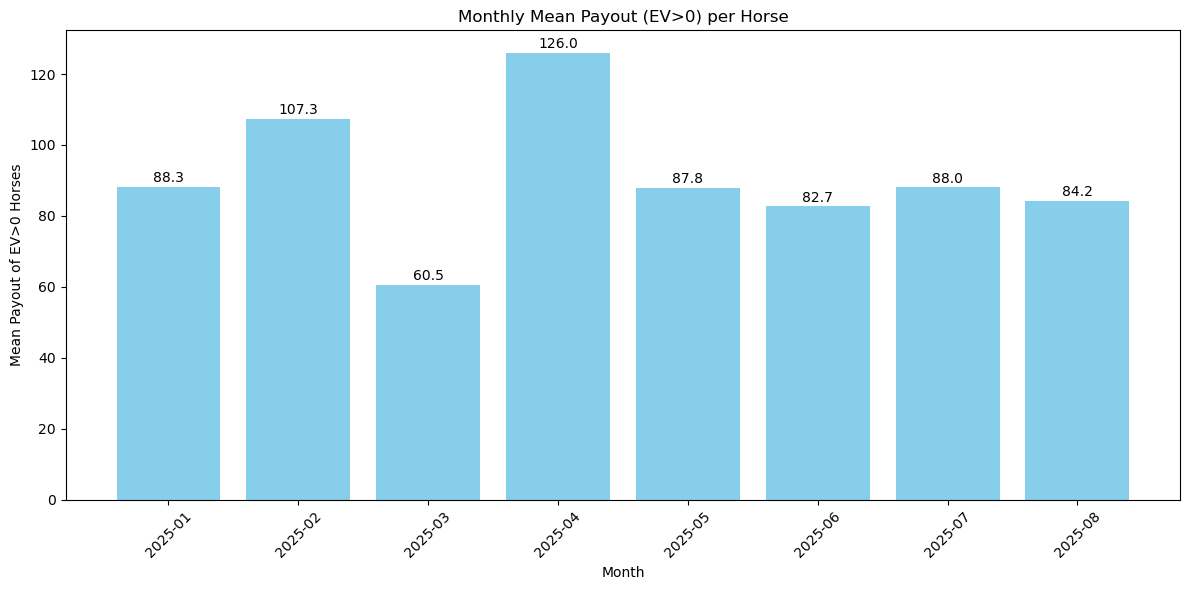

Mean Payout in 2025: 90.60635107980633


In [16]:
valid_start = pd.to_datetime("2025/01/01")
months = []

# Generate month labels
for _ in payouts:
    months.append(valid_start.strftime("%Y-%m"))
    valid_start += relativedelta(months=1)

# Plot histogram / bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(months, payouts, color="skyblue")

# Add text on top of each bar
for bar, payout in zip(bars, payouts):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x-position
        height + 0.5,                       # y-position slightly above the bar
        f"{payout:.1f}",                     # text to display
        ha='center', va='bottom'
    )

plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Mean Payout of EV>0 Horses")
plt.title("Monthly Mean Payout (EV>0) per Horse")
plt.tight_layout()
plt.show()

print("Mean Payout in 2025:", sum(payouts) / len(payouts))


結果を確認すると、平均配当が100円を超えることはできず、現状の条件で馬券を購入すると理論上は損失が出ることがわかります。もちろん、EVの閾値を上げれば平均配当は増加しますが、その場合は月ごとの対象馬が少なくなるため、結果の変動が大きくなります。例えば、EV > 0.1 の場合は平均配当が 93、EV > 0.2 の場合は 103 となり、現在の条件より高くなりますが、月によっては50を切ったりと安定しません。

また、ヒストグラムからも分かるように、月ごとの結果はかなり異なります。これは、ハイパーパラメータチューニング時にFoldごとの最小配当を評価指標として用いても、まだデータが過学習していることを示唆しています。そのため、より安定した評価を行うには、K-Fold の分割数を 5 から 10 などに増やすなどして、各Foldでの結果のばらつきを抑えることが望ましいです。

## Feature Importance （自分用）

学習したLightGBMモデルから特徴量の重要度を確認できます。  
ここでは `importance_type='gain'` を用いて、各特徴量が分岐にどれだけ貢献したか（情報利得）を基準にしています。  

- `get_feature_importance` 関数で、特徴量名と重要度をDataFrameとして取得できます。  
- 重要度の高い上位20特徴量を確認することで、モデルがどの情報を重視して予測しているかを把握できます。  

この情報は、特徴量の選択や追加の前処理、さらなるモデル改善の参考になります。

In [15]:
def get_feature_importance(model):
    importance = model.feature_importance(importance_type='gain')
    feature_names = model.feature_name()

    feat_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values(by='importance', ascending=False)

    feat_imp['order'] = range(1, len(feat_imp) + 1)
    return feat_imp

feat_imp = get_feature_importance(model)
feat_imp.iloc[:20]

,feature,importance,order
124,複勝オッズ,710308.628603,1
123,単勝オッズ,438147.660886,2
41,調教師名,277501.437029,3
114,母父馬名,269709.070708,4
38,騎手名,187406.978982,5
113,父馬名,157109.995853,6
28,人気指数,93251.991503,7
86,馬特記１,34114.207161,8
16,基準複勝オッズ,33551.724689,9
14,基準オッズ,31666.948329,10
